In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os
import sys
import logging

In [19]:
adata_rbpj = "/ocean/projects/cis240075p/skeshari/igvf/bcell2/tcell2/out_data/out_other_methods/paper_data/Rbpj_scRNAseq_final_2samples_RNA.h5ad"
adata_ets1 = "/ocean/projects/cis240075p/skeshari/igvf/bcell2/tcell2/out_data/out_other_methods/paper_data/Ets1_scRNAseq_final_RNA.h5ad"
adata_ikzf1 = "/ocean/projects/cis240075p/skeshari/igvf/bcell2/tcell2/out_data/out_other_methods/paper_data/Ikzf1_scRNAseq_final2_RNA.h5ad"
out_dir = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs"

In [20]:
# from os.path import basename
# import stream as st
# adata = st.read(file_name=adata_infile, workdir=out_dir)

import scanpy as sc
adata_rbpj = sc.read(adata_rbpj)
adata_ets1 = sc.read(adata_ets1)
adata_ikzf1 = sc.read(adata_ikzf1)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_io/h5ad.py:242: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_io/h5ad.py:242: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(


In [21]:
adata_rbpj

AnnData object with n_obs × n_vars = 9072 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [22]:
adata_ets1

AnnData object with n_obs × n_vars = 20618 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'genotype', 'celltype'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [23]:
adata_ikzf1

AnnData object with n_obs × n_vars = 28945 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'celltype2'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

#### Add obs (condition and cluster label)

In [33]:
# the number to label mapping is the same for all TFs

cell_type_annotation = {    "Tpex":[0,1],
                            "Tex": [2,3],}

cell_type_annotation_reverse = {}
for i in set(adata_ikzf1.obs.celltype2):
    for k in cell_type_annotation:
        if int(i) in cell_type_annotation[k]:
            cell_type_annotation_reverse[i] = k
adata_ikzf1.obs["cell_cluster"] = [cell_type_annotation_reverse[i] for i in adata_ikzf1.obs.celltype2]

In [37]:
adata_rbpj.obs['orig.ident']

S2_AAACCCAAGCACACAG-1    S2_sgRbpj
S2_AAACCCACAGGTTACT-1    S2_sgRbpj
S2_AAACGAACAAGGTCGA-1    S2_sgRbpj
S2_AAACGAACAATAGGAT-1    S2_sgRbpj
S2_AAACGCTAGGTTGCCC-1    S2_sgRbpj
                           ...    
S4_TTTGGTTTCGGTTAGT-1     S4_sgNTC
S4_TTTGTTGAGAGCGACT-1     S4_sgNTC
S4_TTTGTTGAGAGGTTTA-1     S4_sgNTC
S4_TTTGTTGCACACTGGC-1     S4_sgNTC
S4_TTTGTTGCAGTTGGTT-1     S4_sgNTC
Name: orig.ident, Length: 9072, dtype: category
Categories (2, object): ['S2_sgRbpj', 'S4_sgNTC']

In [43]:
condition_annotation = {
    "KO": ['S2_sgRbpj', 'S3_sgEts1', 'S4_sgEts1', 'S2_sgIkzf1', 'S4_sgIkzf1'],
    "NTC": ['S4_sgNTC', 'S1_NTC', 'S2_NTC', 'S1_Spike', 'S3_Spike']
}
# Invert the dictionary
sample_to_condition = {}
for condition, samples in condition_annotation.items():
    for sample in samples:
        sample_to_condition[sample] = condition

# Now map it to your adata object
adata_ikzf1.obs["condition"] = adata_ikzf1.obs["orig.ident"].map(sample_to_condition)

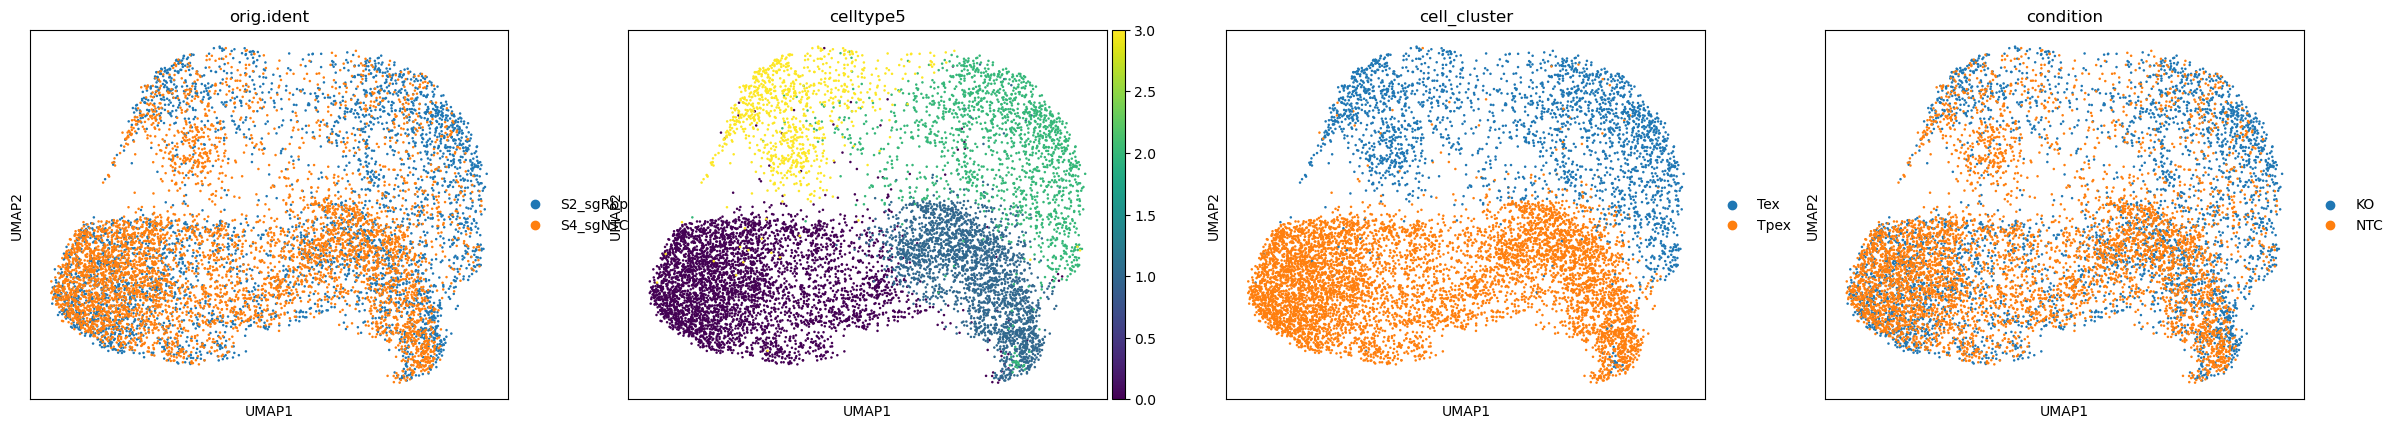

In [40]:
sc.pl.umap(adata_rbpj, color=['orig.ident', 'celltype5', 'cell_cluster', 'condition'])

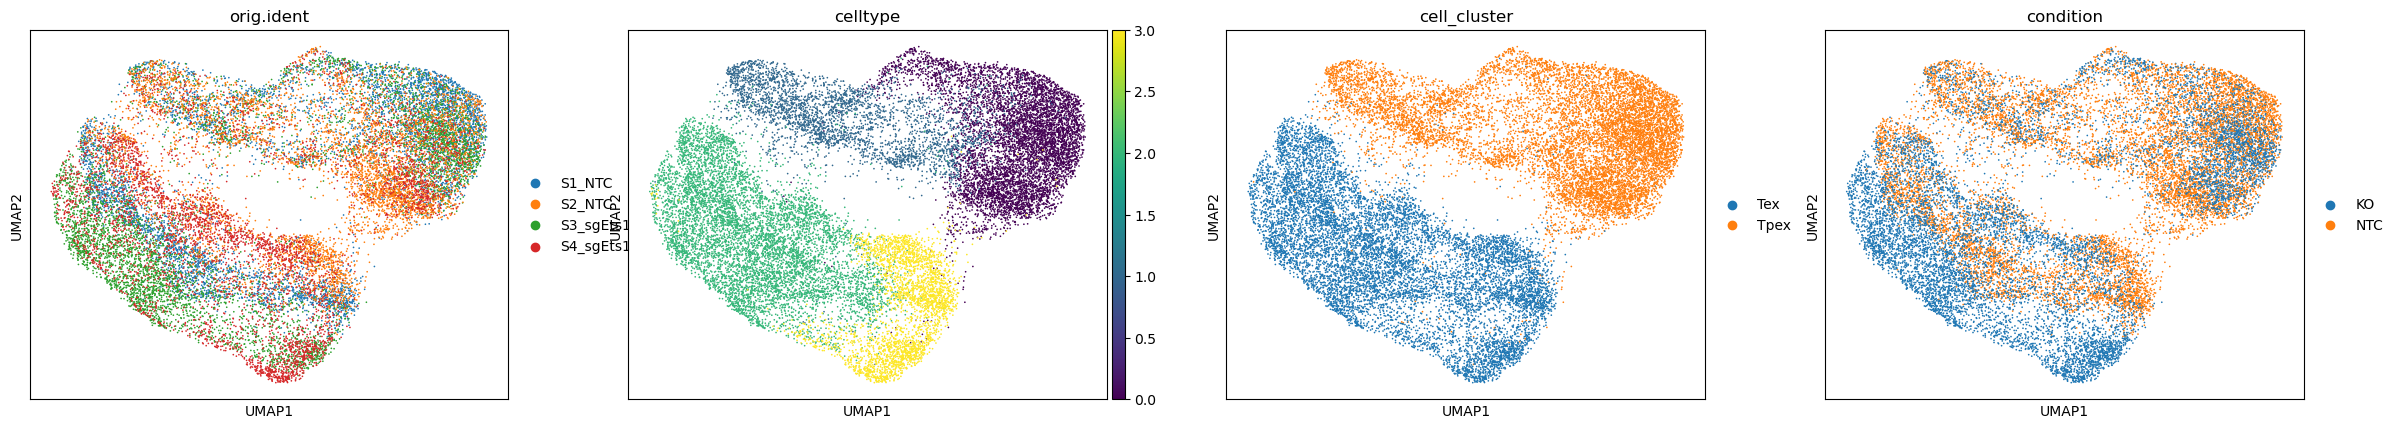

In [42]:
sc.pl.umap(adata_ets1, color=['orig.ident', 'celltype', 'cell_cluster', 'condition'])

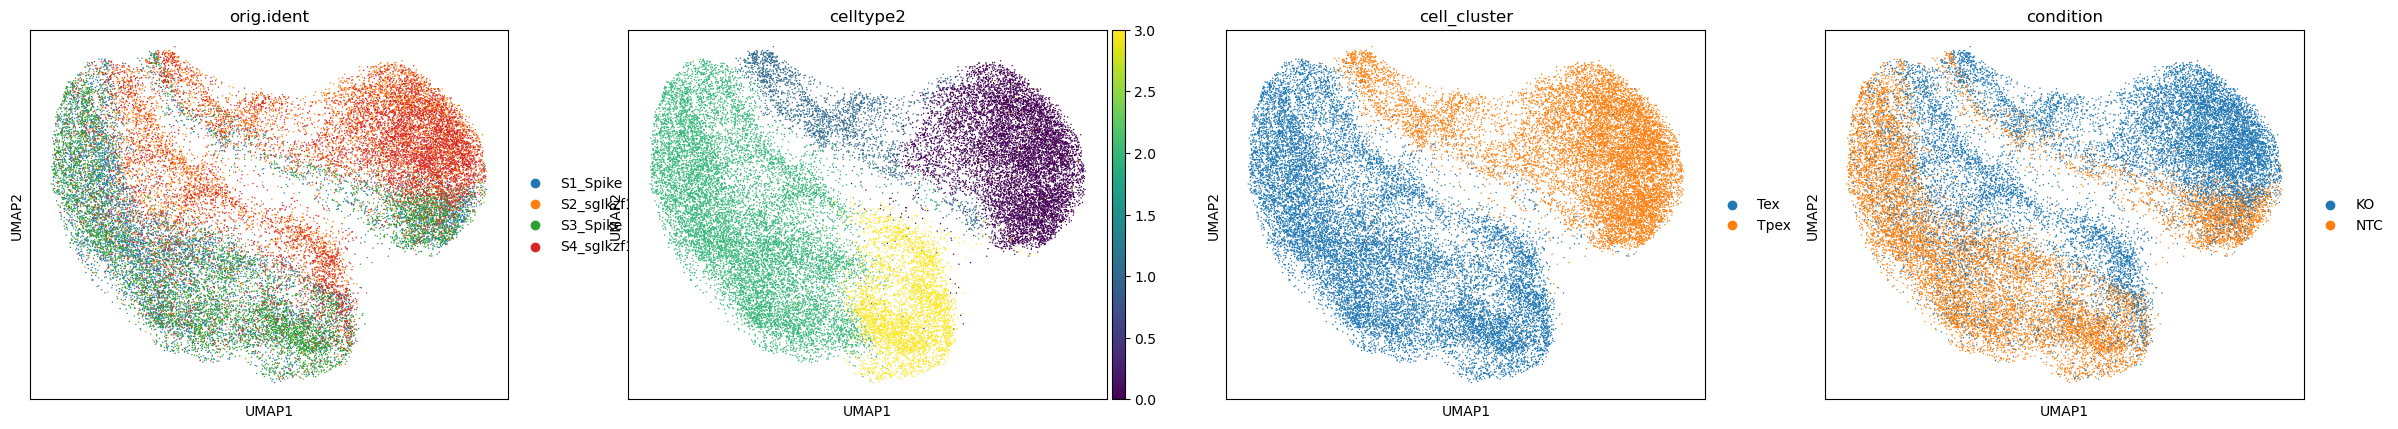

In [44]:
sc.pl.umap(adata_ikzf1, color=['orig.ident', 'celltype2', 'cell_cluster', 'condition'])